# Import 

In [97]:
# Data structure libraries
import pandas as pd
import numpy as np

# ML libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Visualization libraries
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Load Dataset

In [78]:
sleep_data = pd.read_csv('./data/processed_data.csv')

# Data Preprocessing

In [79]:
# Removing unnamed column
sleep_data = sleep_data.loc[:, ~sleep_data.columns.str.contains('^Unnamed')]

In [36]:
# Moving label as the last column
sleep_data = sleep_data[['SEQN', 'RIAGENDR', 'RIDAGEYR', 'SLQ040', 'SLQ050', 'PAQ605', 'PAQ620', 'SMQ040', 'ALQ130',
                         'DIQ010', 'BMXBMI', 'physical_activity', 'smoking', 'alcohol', 'diabetes', 'sleep_disorder']]

# Train - Validation - Test Split

In [39]:
# All feature data
features = sleep_data.iloc[:,:-1]
# All label data
labels = sleep_data.iloc[:,-1:]

# Split into train test, addded parameters to ensure that both groups have similar label distribution
feature_train, feature_test, label_train, label_test = train_test_split(features, labels, test_size=0.1, stratify=labels)

# Using the remaining training records, split into validation, slightly larger split to make it comparable to test size
feature_train, feature_val, label_train, label_val = train_test_split(feature_train, label_train, test_size=0.2, stratify=label_train)

# In the end, we get 3 groups:

# feature_train
# label_train

# feature_test
# label_test

# feature_validation
# label_validation

# Investigating potiential non linear relationships via basis function

In [98]:
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(feature_val[:, None])

InvalidIndexError: (slice(None, None, None), None)

# Hyperparameter Tuning

In [87]:
accuracy_list = []
c_range = np.geomspace(start=0.001, stop=100, num=100)

for c in c_range:
    # Hyperparameter is the number of regularization strength (C), l2 by default
    model = LogisticRegression(solver='liblinear', C=c, random_state=0)
    
    # Learn the model over the training data
    model.fit(feature_train, label_train.values.ravel())

    # Predict labels over the validation data
    model.predict(feature_val)

    # Evaluate accuracy over the validation data
    accuracy_list.append(model.score(feature_val, label_val))

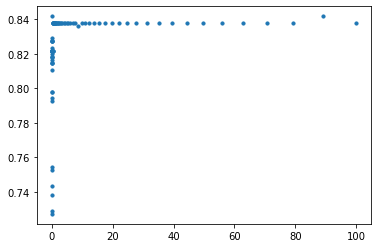

In [88]:
plt.scatter(c_range, accuracy_list, s = 10)
plt.show()

In [89]:
best_accuracy = max(accuracy_list)
best_accuracy_index = accuracy_list.index(best_accuracy)
best_c = c_range[best_accuracy_index]

In [90]:
print('Best Accuracy: ', best_accuracy)
print('Best regularization value', best_c)

Best Accuracy:  0.8418181818181818
Best regularization value 0.05857020818056667


# Logistic Regression

In [ ]:
# Hyperparameter is the number of regularization strength (C), l2 by default
model = LogisticRegression(solver='liblinear', C=best_c, random_state=0)

# Learn the model over the training data
model.fit(feature_train, label_train.values.ravel())

# Predict labels over the validation data
model.predict(feature_test)

# Evaluate accuracy over the validation data
accuracy = model.score(feature_test, label_test)

# Interpret Results

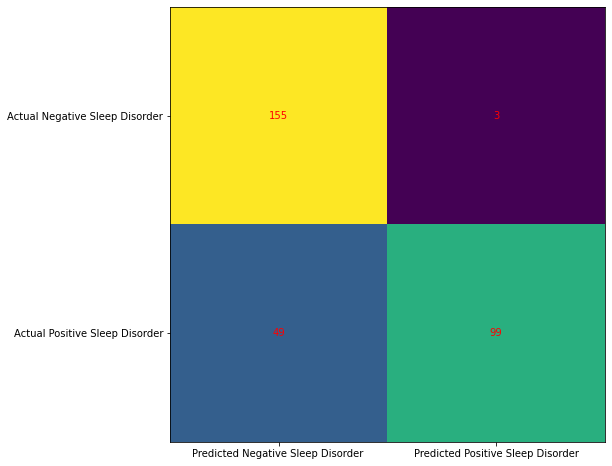

In [94]:
cm = confusion_matrix(label_test, model.predict(feature_test))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Negative Sleep Disorder ', 'Predicted Positive Sleep Disorder'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Negative Sleep Disorder', 'Actual Positive Sleep Disorder'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [96]:
print(classification_report(label_test, model.predict(feature_test)))

              precision    recall  f1-score   support

           0       0.76      0.98      0.86       158
           1       0.97      0.67      0.79       148

    accuracy                           0.83       306
   macro avg       0.87      0.82      0.82       306
weighted avg       0.86      0.83      0.83       306



# Driver (to run entire experiment over k iterations, if needed)